In [13]:
import argparse
import torch
import wandb
import os
import time
import numpy as np
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import DataLoader
from data.dataset import get_cf_dataset,get_ctr_dataset,CTR_Dataset
from utils import seed_everything
from model.nas import Dnis, AdamNas, FM
from shutil import copyfile
import sys
from model import base_model

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("--data_path", type=str, default='data/criteo/datasets.pickle')
parser.add_argument("--exp", type=str, default='nas 31')
parser.add_argument("--cuda", nargs='*', type=int, default=[2,3], help='cuda visible devices')
parser.add_argument("--embedding_dim", type=int, default=64)
parser.add_argument("--batch_size", type=int, default=2048)
parser.add_argument("--lr_w", type=float, default=1e-2)
parser.add_argument("--lr_a", type=float, default=1e-2)
parser.add_argument("--num_epochs", type=int, default=100)
parser.add_argument("--init_alpha", type=float, default=1)
parser.add_argument("--alpha_optim", type=str, default='SGD')
parser.add_argument("--load_checkpoint", type=int, default=1)
parser.add_argument("--warm_start", type=int, default=0)
parser.add_argument("--num_dim_split", type=int, default=64)
parser.add_argument("--search_space", type=str, default='free')
parser.add_argument("--l1", type=float, default=0)
parser.add_argument("--normalize", type=int, default=0)
parser.add_argument("--use_second_grad", type=int, default=1)
parser.add_argument("--model_name", type=str, default='FM')
parser.add_argument("--alpha_upper_round", type=int, default=0)
parser.add_argument("--dataset_type", type=str, default='ctr')
args = parser.parse_args("".split())
os.environ["CUDA_VISIBLE_DEVICES"] = f'{args.cuda}'[1:-1]
device = torch.device('cuda')

In [3]:
train_dataset, val_dataset, test_dataset, num_features = get_ctr_dataset(args.data_path)
val_dataset = val_dataset[0]
test_dataset = test_dataset[0]
num_fields = 39
batch_size = args.batch_size
val_dataloader = DataLoader(val_dataset, batch_size, shuffle=True, num_workers=8, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=8, pin_memory=True)

The dataset has been processed. Reading the cache...


In [6]:
model = getattr(base_model, args.model_name)(num_features, args.embedding_dim, num_fields)

In [8]:
checkpoint = torch.load("checkpoint/GS-SE-ctr-FM-64.tar")

In [11]:
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [12]:
model = model.to(device)

In [13]:
model.eval()

FM(
  (feature_embeddings): Embedding(2086976, 64)
  (feature_biases): Embedding(2086976, 1)
)

In [15]:
val(model,test_dataloader)

(0.45260075076616235, 0.7986788492928761)

In [16]:
arr = np.reshape(model.feature_embeddings.weight.data.abs().detach().cpu(),(-1))
arr = np.sort(arr)
embedding_checkpoint = model.feature_embeddings.weight.data.clone().detach()
losses = []
aucs = []
pruned = []
for i in range(100):
    threshold = arr[int(arr.shape[0]*i/100)]
    model.feature_embeddings.weight.data = embedding_checkpoint.clone().detach()
    model.feature_embeddings.weight.data[model.feature_embeddings.weight.data.abs()<threshold]=0
    loss, auc = val(model,test_dataloader)
    print(f"pruned: {i}%, loss: {loss}, auc: {auc}")
    losses+=[loss]
    aucs+=[auc]
    pruned+=[i]

import seaborn as sns
sns.set()
sns.lineplot(x=pruned,y=aucs)
sns.lineplot(x=pruned,y=losses)

In [4]:
dnis = Dnis(num_features, args.embedding_dim, num_dim_split=args.num_dim_split, search_space=args.search_space,
                normalize=args.normalize, model_name=args.model_name,num_fields=num_fields, feature_split=[51,126,1763,17057,91265,0])

dnis.feature_nums:tensor([     51,     126,    1763,   17057,   91265, 1976714])


In [5]:
dnis.load_state_dict(torch.load("checkpoint/DNIS-CTR_FM_warm_start.pth"))

<All keys matched successfully>

In [6]:
# dnis.load_state_dict(torch.load("wandb/run-20200103_095706-0e3f7p5b/DNIS-CF.tar"))
# dnis.load_state_dict(torch.load("wandb/run-20200112_075137-roh2036g/DNIS-CF-5split.tar"))
# dnis.load_state_dict(torch.load("wandb/run-20200109_074057-oeqtv404/DNIS-CTR.tar"))

In [7]:
dnis.eval()

Dnis(
  (feature_embeddings): Embedding(2086976, 64)
  (model): FM(
    (feature_biases): Embedding(2086976, 1)
  )
)

In [8]:
from sklearn.metrics import roc_auc_score
def val(model, dataloader):
    model.eval()
    running_loss = 0
    pred_arr = np.array([])
    label_arr = np.array([])
    with torch.no_grad():
        for itr, batch in tqdm(enumerate(dataloader)):
            batch = [item.to(device) for item in batch]
            feature_ids, feature_vals, labels = batch
            outputs = model(feature_ids, feature_vals)
            loss = torch.nn.BCEWithLogitsLoss()(outputs.squeeze(), labels.squeeze())
            running_loss += loss.data.detach().cpu().item()
            pred_arr = np.hstack(
                [pred_arr, outputs.data.detach().cpu()]) if pred_arr.size else outputs.data.detach().cpu()
            label_arr = np.hstack(
                [label_arr, labels.data.detach().cpu()]) if label_arr.size else labels.data.detach().cpu()
        val_loss = running_loss / (itr + 1)
        torch.cuda.empty_cache()
    if args.dataset_type == "ctr":
        auc = roc_auc_score(label_arr, pred_arr)
        return val_loss, auc
    return val_loss, 0

In [9]:
dnis=dnis.to(device)
val(dnis,test_dataloader)

(0.45243305496073194, 0.7989111350779803)

In [10]:
arr = np.reshape(dnis.feature_embeddings.weight.data.abs().detach().cpu(),(-1))
arr = np.sort(arr)

In [11]:
embedding_checkpoint = dnis.feature_embeddings.weight.data.clone().detach()

In [14]:
losses = []
aucs = []
pruned = []

# threshold = arr[int(arr.shape[0]*i/100)-1]
# dnis.feature_embeddings.weight.data = embedding_checkpoint.clone().detach()
# dnis.feature_embeddings.weight.data[dnis.feature_embeddings.weight.data.abs()<=threshold]=0
dnis.feature_embeddings.weight.data[:] = 0
loss, auc = val(dnis,test_dataloader)
print(f"pruned: {100}%, loss: {loss}, auc: {auc}")
losses+=[loss]
aucs+=[auc]
pruned+=[i]


pruned: 18%, loss: 0.507574244708355, auc: 0.7640583612975675


In [12]:
losses = []
aucs = []
pruned = []
for i in range(100):
    threshold = arr[int(arr.shape[0]*i/100)]
    dnis.feature_embeddings.weight.data = embedding_checkpoint.clone().detach()
    dnis.feature_embeddings.weight.data[dnis.feature_embeddings.weight.data.abs()<threshold]=0
    loss, auc = val(dnis,test_dataloader)
    print(f"pruned: {i}%, loss: {loss}, auc: {auc}")
    losses+=[loss]
    aucs+=[auc]
    pruned+=[i]


pruned: 0%, loss: 0.45243305496073194, auc: 0.7989111350779803



pruned: 1%, loss: 0.45243299634062817, auc: 0.7989111530202245



pruned: 2%, loss: 0.4524330535637481, auc: 0.7989111274828997



pruned: 3%, loss: 0.4524331618632589, auc: 0.7989111246507409



pruned: 4%, loss: 0.4524329200253955, auc: 0.7989112367513224



pruned: 5%, loss: 0.45243312351937803, auc: 0.7989113710444444



pruned: 6%, loss: 0.45243315761908887, auc: 0.7989115042795146



pruned: 7%, loss: 0.45243247325665187, auc: 0.79891161753082



pruned: 8%, loss: 0.45243070238669003, auc: 0.7989119836708237



pruned: 9%, loss: 0.45243068362719246, auc: 0.7989121479080983



pruned: 10%, loss: 0.4524302485531994, auc: 0.798911286226981



pruned: 11%, loss: 0.45242944581966316, auc: 0.798912232979006



pruned: 12%, loss: 0.45242814287277205, auc: 0.7989116734823903



pruned: 13%, loss: 0.4524265211873821, auc: 0.7989122353011591



pruned: 14%, loss: 0.4524263675058527, auc: 0.7989122995734662



pruned: 15%, loss: 0.45242428077118735, auc: 0.7989130868803231



pruned: 16%, loss: 0.45242293679288453, auc: 0.7989134040743812



pruned: 17%, loss: 0.4524196938744613, auc: 0.7989127292099797


KeyboardInterrupt: 

In [21]:
import seaborn as sns
sns.set()

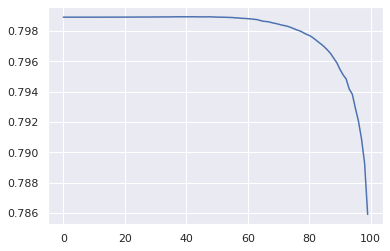

In [27]:
sns.lineplot(x=pruned,y=aucs)

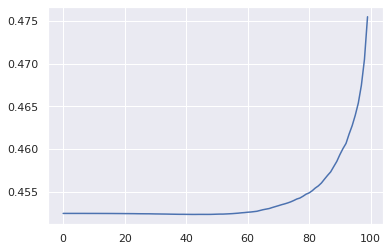

In [28]:
sns.lineplot(x=pruned,y=losses)

In [16]:
arr[int(arr.shape[0]//10*8)]

0.115246296

In [17]:
dnis.feature_embeddings.weight.data = embedding_checkpoint.clone().detach()
dnis.feature_embeddings.weight.data[dnis.feature_embeddings.weight.data.abs()<0.115246296]=0

In [18]:
val(dnis,test_dataloader)

(0.4548419702798128, 0.7977083346645263)

In [31]:
from scipy.sparse import coo_matrix, save_npz, load_npz
scipy_sparse = coo_matrix(embedding_checkpoint.cpu())
save_npz("backup/origin_matrix",scipy_sparse,True)

In [71]:
scipy_sparse = coo_matrix(dnis.feature_embeddings.weight.data.cpu())
save_npz("backup/CP_50",scipy_sparse,True)

In [72]:
!ls -lh backup

total 1.5G
-rw-rw-r-- 1 chengweiyu chengweiyu  44M Oct 30 16:27 'Baseline- FM.tar'
-rw-rw-r-- 1 chengweiyu chengweiyu 1.7M Dec 11 19:07  baseline.log
-rw-rw-r-- 1 chengweiyu chengweiyu  55M Jan 13 14:18  CP_10.npz
-rw-rw-r-- 1 chengweiyu chengweiyu  26M Jan 13 14:21  CP_20.npz
-rw-rw-r-- 1 chengweiyu chengweiyu  17M Jan 13 13:53  CP_25.npz
-rw-rw-r-- 1 chengweiyu chengweiyu 261M Jan 13 14:10  CP_2.npz
-rw-rw-r-- 1 chengweiyu chengweiyu  17M Jan 13 14:24  CP_30.npz
-rw-rw-r-- 1 chengweiyu chengweiyu  11M Jan 13 14:29  CP_50.npz
-rw-rw-r-- 1 chengweiyu chengweiyu 107M Jan 13 14:15  CP_5.npz
-rw-rw-r-- 1 chengweiyu chengweiyu  17K Dec 17 14:52  dense_matrix.npz
-rw-rw-r-- 1 chengweiyu chengweiyu  17K Dec 17 14:52  dense_matrix.pth
-rw-rw-r-- 1 chengweiyu chengweiyu  39M Jan  3 12:41  DNIS-CF.tar
-rw-rw-r-- 1 chengweiyu chengweiyu  49K Oct 28 14:01  dnis-checkpoint.ipynb
-rw-rw-r-- 1 chengweiyu chengweiyu  40K Oct 15 10:52  dnis-cpu.ipynb
-rw-rw-r-- 1 chengweiyu chengweiyu  44K Dec 31 16:2

In [29]:
embedding_array = dnis.feature_embeddings.weight.data.cpu().numpy()

In [31]:
embedding_array = embedding_array.flatten()

In [33]:
import seaborn as sns
sns.set()

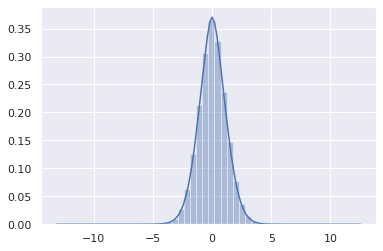

In [34]:
sns.distplot(embedding_array)

In [51]:
dnis.alpha.requires_grad=False
dnis.alpha.data=alpha_checkpoint.clone().detach()

In [52]:
result=[]
thresholds = alpha_checkpoint.view(-1).sort().values[2:]
for threshold in thresholds:
    dnis.alpha[dnis.alpha<=threshold.item()]=0
    test_loss = test(dnis, test_dataloader)
    result+=[[threshold.item(), test_loss]]

Test loss: 0.6178560526278175.
Test loss: 0.6178571033428927.
Test loss: 0.6182456867250262.
Test loss: 0.6185572773950999.
Test loss: 0.6190692593084007.
Test loss: 0.6197725782384638.
Test loss: 0.6204441453589767.
Test loss: 0.621293375176973.
Test loss: 0.6223441124817387.
Test loss: 0.6238610539890703.
Test loss: 0.6251011667315101.
Test loss: 0.6262590775235755.
Test loss: 0.6283504482297624.
Test loss: 0.630178590473093.
Test loss: 0.6325625941523763.
Test loss: 0.6353224724775455.
Test loss: 0.6396649166575221.
Test loss: 0.6422665800105353.
Test loss: 0.646733640586255.
Test loss: 0.6506790181041741.
Test loss: 0.6560256895838213.
Test loss: 0.6615092542449958.
Test loss: 0.6712831889630341.
Test loss: 0.6763216879402028.
Test loss: 0.6791450395325168.
Test loss: 0.6897134868825068.
Test loss: 0.6940156576208404.
Test loss: 0.698728197605395.
Test loss: 0.7042710937437464.
Test loss: 0.7096294710015665.
Test loss: 0.7187213221045791.
Test loss: 0.7455090534735899.
Test loss: 0

In [84]:
import seaborn as sns
import pandas as pd
sns.set()

In [71]:
result = [[37-i,t,e]for i, (t, e) in enumerate(result)]

In [73]:
pd.DataFrame(result,columns=["num_of_units","threshold","MSE"]).iloc[:-5]

,num_of_units,threshold,MSE
0,37,0.000089,0.617856
1,36,0.000131,0.617857
2,35,0.019953,0.618246
3,34,0.022169,0.618557
4,33,0.025106,0.619069
5,32,0.025827,0.619773
6,31,0.026152,0.620444
7,30,0.030617,0.621293
8,29,0.031363,0.622344
9,28,0.033057,0.623861


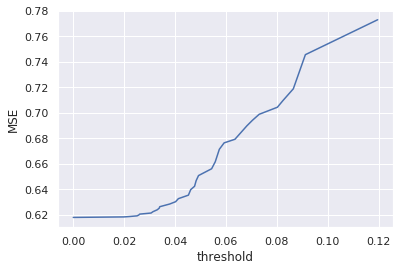

In [85]:
sns.lineplot(x="threshold", y="MSE", data=pd.DataFrame(result,columns=["num_of_units","threshold","MSE"]).iloc[:-5])

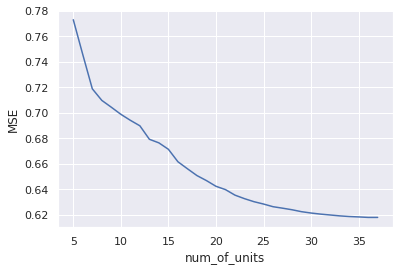

In [86]:
sns.lineplot(x="num_of_units", y="MSE", data=pd.DataFrame(result,columns=["num_of_units","threshold","MSE"]).iloc[:-5])

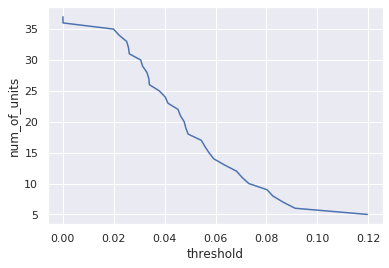

In [87]:
sns.lineplot(x="threshold", y="num_of_units", data=pd.DataFrame(result,columns=["num_of_units","threshold","MSE"]).iloc[:-5])

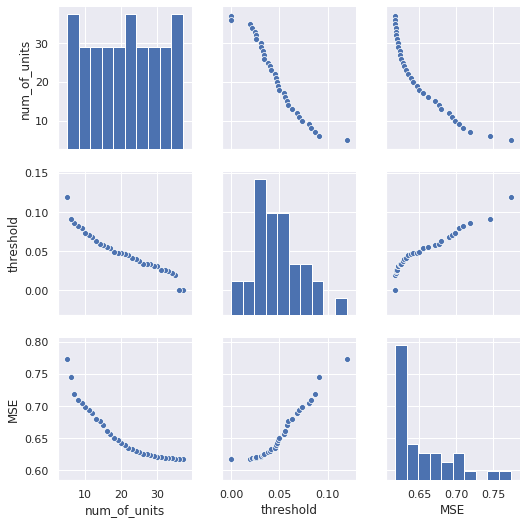

In [88]:
sns.pairplot(data=pd.DataFrame(result,columns=["num_of_units","threshold","MSE"]).iloc[:-5])